# Dataset Preparation

### Imports

In [4]:
import h5py
import os
import pathlib as pl

import pandas as pd
import tqdm
import pickle
import pandas as pd
from itertools import chain
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

### Read Files and Save Data Accordingly

In [7]:
path = pl.Path("../..", "data", "embeddings.h5")  # adjust this path
if os.path.isfile(path):
    embeddings = h5py.File(path)

In [8]:
encoded_keys = list(embeddings.keys())

In [10]:

line_path = pl.Path("../..", "data", "labels")  # adjust this path... it leads to the 3line files
line_path_names = os.listdir(line_path)

data = dict()
for file in tqdm.tqdm(line_path_names):
    file_path = pl.Path(line_path, file)

    label = []
    if "Glob" in file.split(".")[0]:
        label.append("G")
    if "SP" in file.split(".")[0]:
        label.append("SP")
    if "TM" in file.split(".")[0]:
        label.append("TM")

    label = "_".join(label)

    data[label] = dict()
    with open(file_path, "r") as f:
        prot_id = ""
        for line_index, line in enumerate(f, 0):
            line = line.strip()
            if line == "":
                continue
            if line.startswith(">"):
                prot_id = line.replace(">", "")

                if "|" in line:
                    prot_id = prot_id.split("|")[0]
                data[label][prot_id] = list()
                continue

            data[label][prot_id].append(line)

100%|██████████| 4/4 [00:00<00:00, 71.28it/s]


In [11]:
import hashlib

all_generated_hashes = []
for label in data:
    for protein in data[label]:
        seq = data[label][protein][0].encode("UTF-8")
        hashed = hashlib.md5(seq).hexdigest()
        data[label][protein].append(hashed)
        all_generated_hashes.append(hashed)

In [12]:
len(all_generated_hashes)
len(encoded_keys)

print(len(set(all_generated_hashes) - set(encoded_keys)))  # 0
print(len(set(encoded_keys) - set(all_generated_hashes)))  # 0

0
0


In [18]:
path = pl.Path("../..", "data", 'seq_anno_hash.pickle')
with open(path, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Structure

In [19]:
print(data.keys())
print(list(data["G"].keys())[:10], " ...")
print(len(data["G"]["P38448"]))

dict_keys(['G_SP', 'G', 'SP_TM', 'TM'])
['P38448', 'Q00594', 'P27888', 'P0CL03', 'P15034', 'P09961', 'P14898', 'Q9X758', 'Q7VAL5', 'P07642']  ...
3


### Train / Test Split

In [20]:
label_prot = [list(map(lambda x:[x,key], list(data[key].keys()))) for key in data]
label_prot = list(chain.from_iterable(label_prot))
label_prot = pd.DataFrame(label_prot, columns=["prot_id", "label"])

X_train, X_test = train_test_split(label_prot, test_size = 0.1, train_size=0.9, random_state=42, stratify=label_prot["label"])
print(X_train)
print(X_test)

     prot_id  label
1240  P31716   G_SP
2049  Q24537      G
1660  Q9VWW0      G
3495  Q0GGX2      G
1260  P13423   G_SP
...      ...    ...
1801  P18146      G
4276  Q21874  SP_TM
2501  Q13415      G
2687  Q9HGP0      G
582   Q13093   G_SP

[4638 rows x 2 columns]
     prot_id label
898   P13507  G_SP
532   P08118  G_SP
3871  P13375     G
1500  Q38897     G
3918  A5U654     G
...      ...   ...
4159  P31473     G
1960  P49311     G
3110  P41900     G
88    P83886  G_SP
1922  Q9DEN4     G

[516 rows x 2 columns]


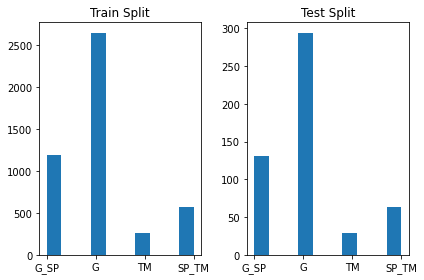

In [21]:
fig, ax = plt.subplots(1,2, tight_layout=True, sharex=True)
ax[0].set(title="Train Split")
ax[1].set(title="Test Split")
ax[0].hist(X_train["label"])
ax[1].hist(X_test["label"])
plt.show()

## Save test and train splits for models

In [24]:
X_train.to_csv("../data_splits/train_prot_id_labels.csv",index=False)
X_test.to_csv("../data_splits/test_prot_id_labels.csv", index=False)